1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.


In [2]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [5]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
def entropy_shannon(labels):
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
 #   base = e if base is None else base
    impurity = -(norm_counts * np.log2(norm_counts)).sum()
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criterion- p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_criterion = criterion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criterion, max_depth, depth=0):
    if depth < max_depth: # критерий остановки по максимальной глубине дерева
        quality, t, index = find_best_split(data, labels, criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        depth += 1
    # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, criterion, max_depth)
        false_branch = build_tree(false_data, false_labels, criterion, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    else:
        return Leaf(data, labels)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
#создаем выборку возраст, запралата
classification_data = np.array([[18, 30000], [25, 70000], [32, 80000], [17, 5000], [16, 0], [24, 40000], [45, 55000], [37, 150000], [33, 40000], 
                                [25, 90000], [26, 37000], [27, 100000], [27, 120000], [23, 35000], [19, 23000], [21, 200000], [31, 80000], [39, 35000],
                                [41, 55000], [18, 30000], [25, 70000], [32, 80000], [17, 5000], [16, 0], [24, 40000], [45, 55000], [37, 150000], 
                                [34, 40000], [43, 90000], [28, 37000], [55, 100000], [53, 120000], [21, 35000], [16, 23000], [45, 200000], [38, 80000], 
                                [59, 35000], [40, 55000], [18, 30000], [25, 70000], [32, 80000], [17, 5000], [16, 0], [24, 40000], [45, 55300], 
                                [37, 137800], [33, 44500], [25, 95000], [26, 32000], [27, 10000], [27, 11500], [23, 37000], [19, 230000], [21, 20000],
                                [31, 31000], [39, 8000], [41, 59000], [18, 30000], [25, 70000], [32, 80000], [18, 5000], [16, 0], [24, 40000], 
                                [62, 55000], [59, 150000], [68, 40000], [51, 90000], [71, 37000], [59, 35000], [40, 55000], [18, 30000], [25, 70000], 
                                [32, 80000], [17, 5000], [16, 0], [24, 40000], [45, 55300], [37, 137800], [33, 44500], [25, 95000], [26, 32000], 
                                [27, 10000], [27, 11500], [23, 37000], [19, 230000], [21, 20000], [37, 137800], [33, 44500], [25, 95000], [26, 32000], [27, 10000], [27, 11500], [23, 37000], [19, 230000], [21, 20000],
                                [31, 31000], [39, 8000], [41, 59000], [18, 30000], [25, 70000]])
len(classification_data)

100

In [16]:
classification_labels = np.array([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0])
len(classification_labels)

100

In [17]:
#Функция нормализации данных. 
def calc_norm_feat(x: np.array):
    res = (x - x.min(axis=0)) / (x.max(axis=0)- x.min(axis=0))
    return res

In [18]:
#Нормализуем данные
data = classification_data.copy()
data = calc_norm_feat(data)
#data

In [19]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.25,
                                                                                     random_state = 1)

In [20]:
# Построим дерево решений
tree_shannon = build_tree(train_data, train_labels, entropy_shannon, max_depth = 3)
tree_gini = build_tree(train_data, train_labels, gini, max_depth = 3)
# print_tree(my_tree_shannon), print_tree(my_tree_gini)

In [21]:
# Ответы для обучающей выборки
answers_train_shannon = predict(train_data, tree_shannon) 
answers_train_gini = predict(train_data, tree_gini)
#print(answers_train_shannon)
#print(answers_train_gini)

In [22]:
# Ответы для тетсовой выборки
answers_test_shannon = predict(test_data, tree_shannon)
answers_test_gini = predict(test_data, tree_gini)
print(answers_test_shannon)
print(answers_test_gini)

[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]


In [23]:
# Точность обучающей выборки
accuracy_train_shannon = accuracy_metric(train_labels, answers_train_shannon)
accuracy_train_gini = accuracy_metric(train_labels, answers_train_gini)
print(f"Точность обучающей выборки с энтропией Шеннона: {accuracy_train_shannon}")
print(f"Точность обучающей выборки с критерием Джини: {accuracy_train_gini}")

Точность обучающей выборки с энтропией Шеннона: 76.0
Точность обучающей выборки с критерием Джини: 76.0


In [25]:
#Точность тестовой выборки
accuracy_test_shannon = accuracy_metric(test_labels, answers_test_shannon)
accuracy_test_gini = accuracy_metric(test_labels, answers_test_gini)
print(f"Точность обучающей выборки с энтропией Шеннона: {accuracy_test_shannon}")
print(f"Точность обучающей выборки с критерием Джини: {accuracy_test_gini}")

Точность обучающей выборки с энтропией Шеннона: 44.0
Точность обучающей выборки с критерием Джини: 44.0


На данной вборки критерий Джини и Энтропия Шенона показали одинаковые результаты. Однко, данная выборка была сгенерированна вручную, она достаточно мала (для деревьев решений требуется болльшое количество данных) и имеет не точные исходные данные в связи с чем, могут ошибочные результаты тестов. Протестируем данные на сгенирированных автоматически данных.

In [26]:
class_data, class_labels = datasets.make_classification(n_samples = 1000,
                                                        n_features = 2, 
                                                        n_informative = 2, 
                                                        n_classes = 2, 
                                                        n_redundant = 0, 
                                                        n_clusters_per_class = 1, 
                                                        random_state = 5)

In [27]:
train2_data, test2_data, train2_labels, test2_labels = model_selection.train_test_split(class_data, 
                                                                                     class_labels, 
                                                                                     test_size = 0.25,
                                                                                     random_state = 1)

In [29]:
# Построим дерево решений
tree_sh = build_tree(train2_data, train2_labels, entropy_shannon, max_depth = 5)
tree_g = build_tree(train2_data, train2_labels, gini, max_depth = 5)
# print_tree(my_tree_shannon), print_tree(my_tree_gini)

In [31]:
# Ответы для обучающей выборки
answers_train_sh = predict(train2_data, tree_sh) 
answers_train_g = predict(train2_data, tree_g)

In [33]:
# Ответы для тетсовой выборки
answers_test_sh = predict(test2_data, tree_sh)
answers_test_g = predict(test2_data, tree_g)
#print(answers_test_sh)
#print(answers_test_g)

In [34]:
# Точность обучающей выборки
accuracy_train_sh = accuracy_metric(train2_labels, answers_train_sh)
accuracy_train_g = accuracy_metric(train2_labels, answers_train_g)
print(f"Точность обучающей выборки с энтропией Шеннона: {accuracy_train_sh}")
print(f"Точность обучающей выборки с критерием Джини: {accuracy_train_g}")

Точность обучающей выборки с энтропией Шеннона: 98.13333333333333
Точность обучающей выборки с критерием Джини: 97.6


In [35]:
#Точность тестовой выборки
accuracy_test_sh = accuracy_metric(test2_labels, answers_test_sh)
accuracy_test_g = accuracy_metric(test2_labels, answers_test_g)
print(f"Точность обучающей выборки с энтропией Шеннона: {accuracy_test_sh}")
print(f"Точность обучающей выборки с критерием Джини: {accuracy_test_g}")

Точность обучающей выборки с энтропией Шеннона: 97.2
Точность обучающей выборки с критерием Джини: 97.2


На обучающей выборки энтропия Шеннона показала точность выше. На тестовых данных точность оказалась также однаковой.

In [37]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


In [59]:
colors = ListedColormap(['orange', 'green'])
light_colors = ListedColormap(['bisque', 'lightgreen'])

<ipython-input-60-5a02fbae881e>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-60-5a02fbae881e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=97.20')

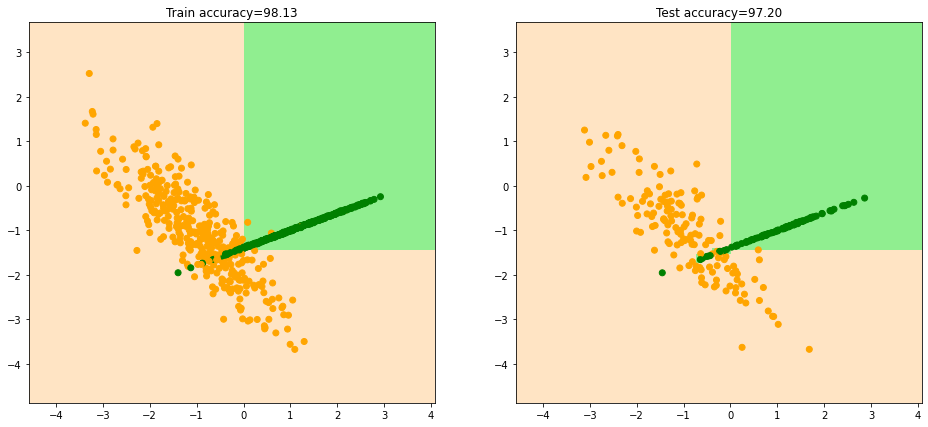

In [60]:
# сгенерированная выборка
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train2_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree_sh)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train2_data[:, 0], train2_data[:, 1], c = train2_labels, cmap = colors)
plt.title(f'Train accuracy={accuracy_train_sh:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test2_data[:, 0], test2_data[:, 1], c = test2_labels, cmap = colors)
plt.title(f'Test accuracy={accuracy_test_sh:.2f}')

<ipython-input-62-22d9f39935f4>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-62-22d9f39935f4>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=44.00')

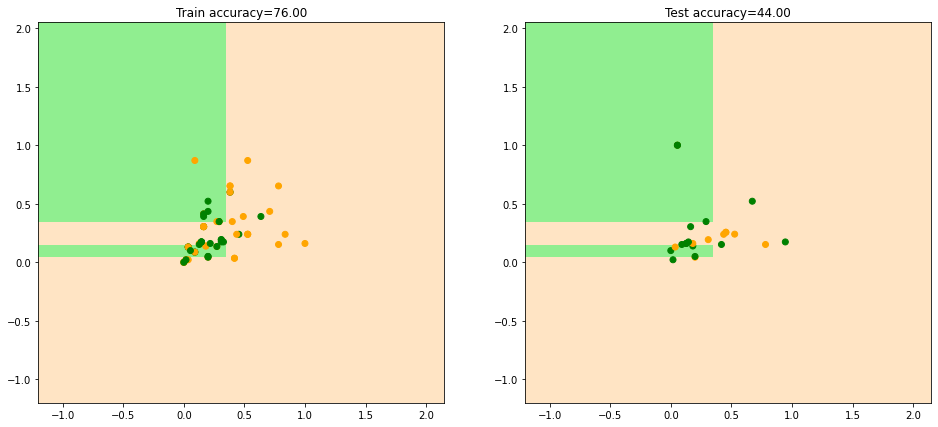

In [62]:
#Выборка созданная вручную
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree_shannon)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={accuracy_train_shannon:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={accuracy_test_shannon:.2f}')